Atividade 04 da disciplina de Visão Robótica

Discente: Henrique Antônio Guanais Corneau

# Filtro Canny

Para implementar o filtro Canny de detecção de bordas, é necessário seguir o seguinte algoritmo:

• Redução de ruídos

• Cálculo do Gradiente

• Non Maximum Suppression

• Thresholding duplo

• Histerese


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

O primeiro passo consiste em realizar a redução de ruído da imagem para que o ruído não atrapalhe a detecção de bordas da imagem, e para isso é utilizado um filtro Gaussiano. O filtro utilizado nesse projeto possui um kernel 3x3.

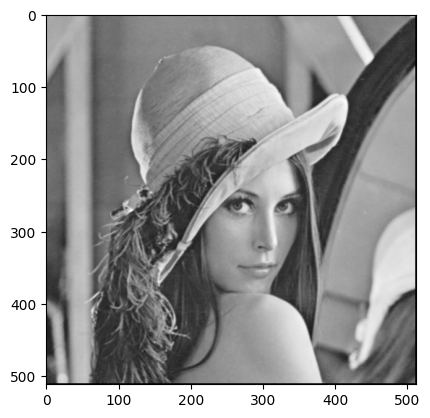

In [21]:
# primeiro passo - Filtro gaussiano
def filtro_espacial(img, k):
    img2 = np.zeros_like(img, dtype=np.float32)
    lk = k.shape[0] 
    ck = k.shape[1] 
    llin = int(lk/2) 
    lcol = int(ck/2)
    # convolucao entre o filtro e a imagem
    for i in range(llin, img.shape[0] - llin):
        for j in range(lcol, img.shape[1] - lcol):
            region = img[i - llin:i + llin + 1, j - lcol:j + lcol + 1]
            img2[i, j] = np.sum(region * k)

    return img2
# gerar filtro gaussiano de tamanho size
def gaussian_kernel(size, k, sigma):
    kernel = np.zeros((size,size))
    llin = int(size/2) 
    lcol = llin 
    for m in range(-llin, llin+1):
        for n in range(-lcol, lcol+1):
            kernel[m+llin, n+lcol] = k * np.exp(-(m**2 + n**2)/(2*sigma**2))
            kernel = kernel/np.sum(kernel)
    return kernel

kernel = gaussian_kernel(3, 1, 2)
img_path = '../imagens/Lenna.png'
img = cv2.imread(img_path)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_filtro = filtro_espacial(gray_image, kernel)
plt.imshow(img_filtro, cmap='gray')
plt.show()

O segundo passo consiste em realizar o cálculo do gradiente, e para isso é utilizado o filtro de Sobel nas direções x e y.

O gradiente foi calculado utilizando a norma Euclidiana: `magnitude = np.sqrt(sobelx**2 + sobely**2)`, e a visualização foi possível através de: `img_filtro_sobel = cv2.convertScaleAbs(magnitude`

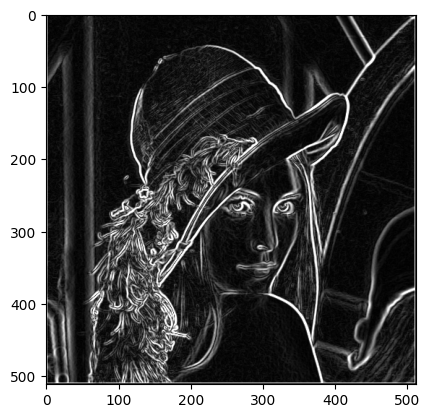

In [22]:
# segundo passo - filtro de sobel
def filtro_sobel(img, k):
    img2 = np.zeros_like(img, dtype=np.float32)
    lk = k.shape[0] 
    ck = k.shape[1] 
    llin = int(lk/2) 
    lcol = int(ck/2)
    
    for i in range(llin, img.shape[0] - llin):
        for j in range(lcol, img.shape[1] - lcol):
            region = img[i - llin:i + llin + 1, j - lcol:j + lcol + 1]
            img2[i, j] = np.sum(region * k)

    return img2

k1 = np.array([[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]])
k2 = np.array([[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]])
# calculo do gradiente
sobelx = filtro_sobel(img_filtro, k1)
sobely = filtro_sobel(img_filtro, k2)
magnitude = np.sqrt(sobelx**2 + sobely**2)
# visuzalicao do gradiente
img_filtro_sobel = cv2.convertScaleAbs(magnitude)

plt.imshow(img_filtro_sobel, cmap='gray')
plt.show()


O terceiro passo é realizar o Non maximum supression, que tem o objetivo de diminuir a espessura das bordas detectadas pelo filtro de Sobel para somente 1 pixel.

Para realizar a contração foi calculado a direção do gradiente, e o pixel que fica na borda será o pixel de maior valor na direção do gradiente, comparando então com seus vizinhos.

Para realizar essa supressão, foram analisados os vizinhos em 4 direções de gradiente, e caso o ângulo do gradiente seja menor que zero, o ângulo é somado com 180º. 


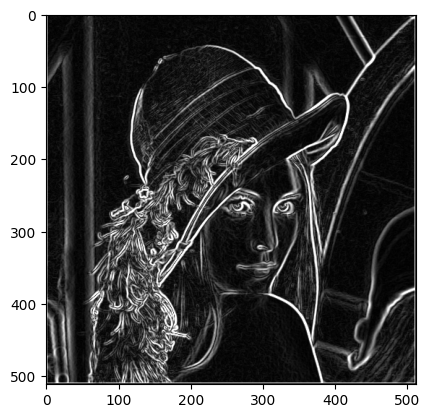

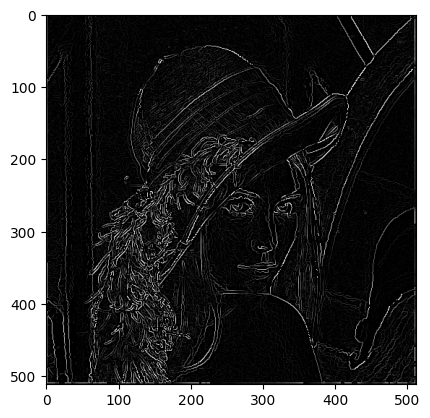

In [23]:
# passo 3 - non-maximum suppression
def non_maximum_supression(img, theta, magnitude):
    img2 = np.zeros_like(img)
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            ang = theta[i, j]*180/np.pi
            if magnitude[i, j] > 0:
                if ang < 0:
                    ang += 180
                if (0 <= ang < 22.5) or (157.5 <= ang <= 180):
                    if magnitude[i, j] >= magnitude[i - 1, j] and magnitude[i, j] >= magnitude[i + 1, j]:
                        img2[i, j] = magnitude[i, j]
                elif 22.5 <= ang < 67.5:
                    if magnitude[i, j] >= magnitude[i - 1, j - 1] and magnitude[i, j] >= magnitude[i + 1, j + 1]:
                        img2[i, j] = magnitude[i, j]
                elif (67.5 <= ang < 112.5):
                    if magnitude[i, j] >= magnitude[i, j - 1] and magnitude[i, j] >= magnitude[i, j + 1]:
                        img2[i, j] = magnitude[i, j]
                elif 112.5 <= ang < 157.5:
                    if magnitude[i, j] >= magnitude[i + 1, j - 1] and magnitude[i, j] >= magnitude[i - 1, j + 1]:
                        img2[i, j] = magnitude[i, j]
    return img2

theta = np.arctan2(sobelx, sobely)
img_suprimida = non_maximum_supression(img_filtro_sobel, theta, magnitude)

plt.imshow(img_filtro_sobel, cmap='gray')
plt.show()
plt.imshow(img_suprimida, cmap='gray')
plt.show()


O próximo passo é fazer p Thresholding duplo, em que consiste em definir dois níveis de thresholding `t1` e `t2` para caracterizar as bordas como borda forte ou borda fraca, e para pixels com valores menores que `t1` seu valor vira 0.

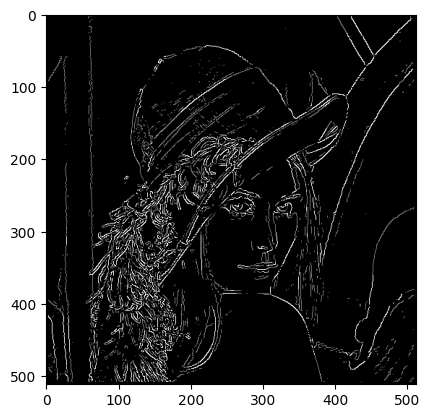

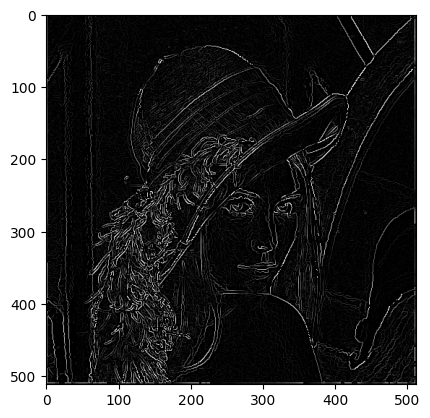

In [24]:
# passo 4 - thresholding duplo

def thresholding(img, t1, t2):
    img2 = np.zeros_like(img)
    for i in range(3, img.shape[0] - 3):
        for j in range(3, img.shape[1] - 3):
            if img[i, j] < t1:
                img2[i, j] = 0
            elif img[i, j] > t2:
                img2[i, j] = 255
            else:
                img2[i, j] = 128
    
    return img2

img_threshold = thresholding(img_suprimida, 60, 130)
plt.imshow(img_threshold, cmap='gray')
plt.show()
plt.imshow(img_suprimida, cmap='gray')
plt.show()

O passo final é fazer a Histerese, que tem como objetivo ligar as bordas fortes, transformando pixels de borda fraca em forte caso sejam vizinhos de pixels de borda forte.

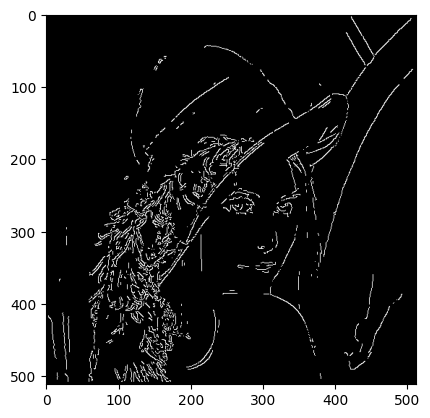

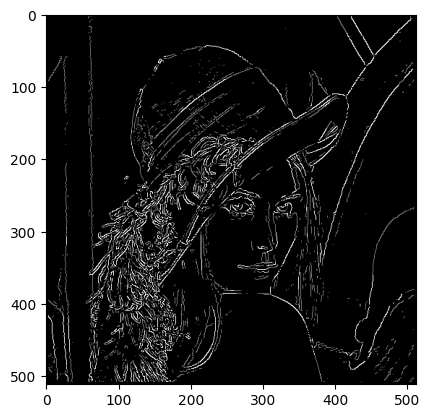

In [26]:
# passo 5 - histerese

def histerese(img):
    img2 = np.zeros_like(img)
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            if img[i, j] == 128:
                if (img[i - 1, j - 1] == 255 or img[i - 1, j] == 255 or img[i - 1, j + 1] == 255 or
                    img[i, j - 1] == 255 or img[i, j + 1] == 255 or img[i + 1, j - 1] == 255 or
                    img[i + 1, j] == 255 or img[i + 1, j + 1] == 255):
                    img2[i, j] = 255
                else:
                    img2[i, j] = 0
            else:
                img2[i, j] = img[i, j]
    return img2

img_histerese = histerese(img_threshold)
# plota a imagem com filtro de canny
plt.imshow(img_histerese, cmap='gray')
plt.show()
# plota a imagem resultado do processo anterior
plt.imshow(img_threshold, cmap='gray')
plt.show()

# Transformada de Hough

Para realizar a transformada de Hough em uma imagem que passou pelo filtro de Canny, primeiro é feito uma função `hough_lines_acc()` para calcular a matriz acumuladora `H`, em que é incrementada na posição `(𝜃, 𝜌)`, para cada pixel de borda.

Depois, a função `hough_peaks()`, procura os `num_peaks` pontos de máximo dessa matriz H, em que estão suficientemente longes de si, representando retas diferentes.

Posteriormente, as retas são plotadas através de `plot_lines()`, em que através desses pontos de máximo encontrados, são plotadas retas na imagem real, através da conversão das coordenadas `(𝜃, 𝜌)` para coordenadas cartesianas.

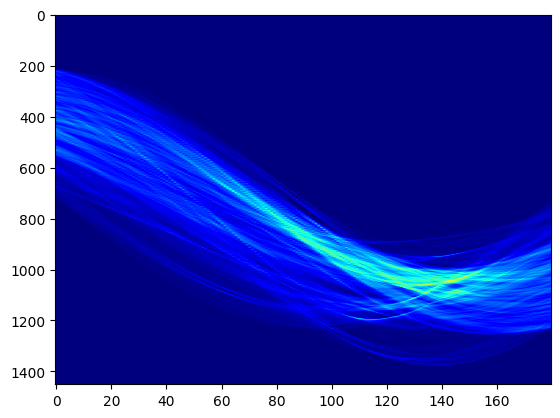

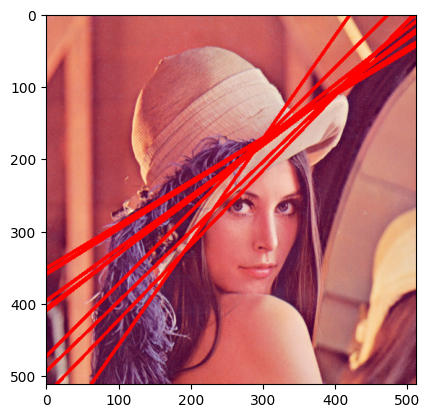

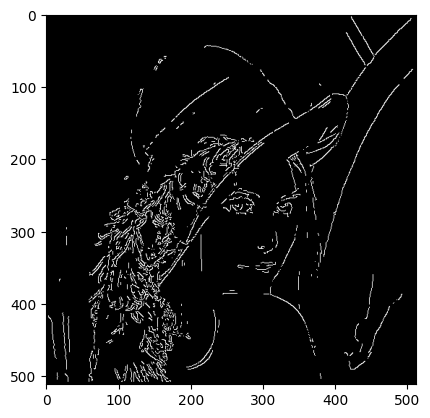

In [27]:
# hough transform

def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    '''Calcula o acumulador de Hough, thetas e rhos para linhas retas.'''
    height, width = img.shape
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2))  
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # inicializando acumulador Hough
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # indices dos pixels de borda

    # iteracao sobre os pixels de borda
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        # calcula rho para cada theta
        for j in range(len(thetas)):
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H, thetas, rhos

def hough_peaks(H, num_peaks):
    '''Calcula os n pontos de máximo no acumulador Hough.'''
    indices = np.argpartition(H.flatten(), -num_peaks)[-num_peaks:]
    indices = np.vstack(np.unravel_index(indices, H.shape)).T
    return indices

def plot_lines(img, indices, rhos, thetas, num_peaks):
    '''Desenha as n linhas correspondentes aos pontos de máximo.'''
    img2 = np.copy(img)
    
    for i in range(num_peaks):
        rho = rhos[indices[i][0]]
        theta = thetas[indices[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(img2, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
    return img2

H, thetas, rhos = hough_lines_acc(img_histerese)

ind = hough_peaks(H, 10)
img_lines = plot_lines(img, ind, rhos, thetas, 10)
# plota o acumulador Hough
plt.imshow(H, cmap='jet', aspect='auto')
plt.show()
# plota as linhas detectadas
plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
plt.show()
# plota a imagem com filtro de canny
plt.imshow(img_histerese, cmap='gray')
plt.show()



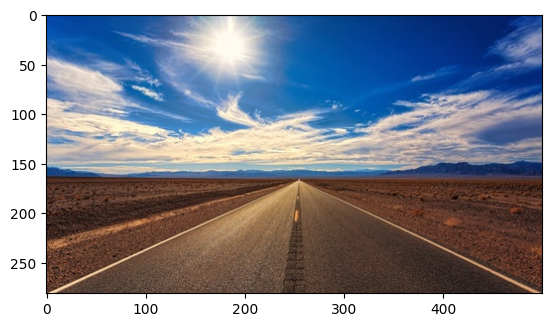

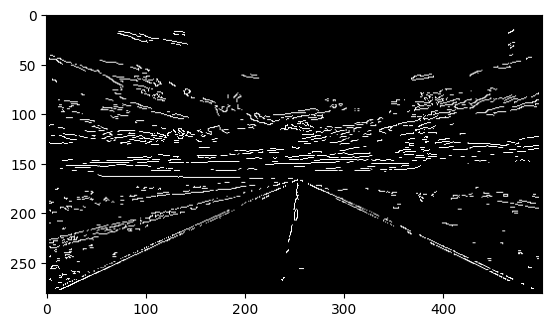

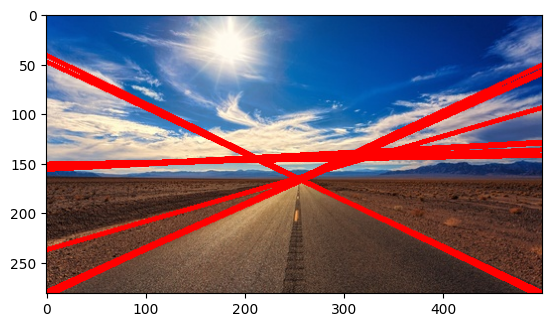

In [32]:
# juntando as funcoes e utilizando em uma imagem qualquer
def canny_filter(img):
    img2 = np.copy(img)
    gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kernel = gaussian_kernel(3, 1, 2)
    img_filtro = filtro_espacial(gray_image, kernel)
    
    k1 = np.array([[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]])
    k2 = np.array([[-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]])
    sobelx = filtro_sobel(img_filtro, k1)
    sobely = filtro_sobel(img_filtro, k2)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    img_filtro_sobel = cv2.convertScaleAbs(magnitude)

    theta = np.arctan2(sobelx, sobely)
    img_suprimida = non_maximum_supression(img_filtro_sobel, theta, magnitude)

    img_threshold = thresholding(img_suprimida, 60, 130)

    img_histerese = histerese(img_threshold)
    
    return img_histerese

def hough_transform(img, img_canny, n):
    H, thetas, rhos = hough_lines_acc(img_canny)

    ind = hough_peaks(H, n)
    img_lines = plot_lines(img, ind, rhos, thetas, n)
    
    return img_lines

img_path = '../imagens/estrada.jpg'
img = cv2.imread(img_path)

canny_img = canny_filter(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
hough_img = hough_transform(img, canny_img, 10)

plt.imshow(canny_img, cmap='gray')
plt.show()
plt.imshow(cv2.cvtColor(hough_img, cv2.COLOR_BGR2RGB))
plt.show()